In [1]:
#path = 'saved_model_1001_1' #epoch 60 / 20  large image x3
#path = 'saved_model_1001_softmax_RMSprop_80_30' Not bad, little noisy.
#path = 'saved_model_1001_softmax_RMSprop_100_30_0.0001' #less noisy but stamp not really good
#path = 'saved_models/saved_model_1001_softmax_RMSprop_100_40_0.0005' #less noisy. stamp better.
#path = 'saved_model_1001_softmax_Adam_100_40_0.0005' #little bit worse
#path = 'saved_model_1005_softmax_RMSprop_100_40_0.0005_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_100_30_0.0005_B8_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_50_30_0.0005_B16_with_classweights_100'
#path = 'saved_model_1005_RMSprop_100_0.0005_B1_classweights_P5_S10'
#path = 'saved_model_1005_RMSprop_80_0.0005_BNone_classweights_P5_S30'
#path = 'saved_model_1006_Adam_70_0.0005_BNone_classweights_P5_S50'
path = 'saved_model_1006_RMSprop_70_0.0005_BNone_classweights_P86_S3055'

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.2.0


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Ground Truth Mask', 'Pushed', 'Stamped']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #plt.savefig("EX_1.png")
    plt.axis('off')

  plt.show()

In [5]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

  

In [6]:
mask = imread('images/test/gt_mask/일반7__분리막 눌림_검정.png') #2048 x 2448

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

color_dict = {i: list(x) for i,x in enumerate(colors)}
print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.9607843, 0.5764706, 0.19215687], 2: [0.98039216, 0.19607843, 0.3254902], 3: [0.98039216, 0.98039216, 0.21568628]}


In [7]:
import glob
import cv2
import gc
gc.collect()

train_x = []
train_y = []

for img in glob.glob("images/train/*/*.bmp"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,576)) #960,1152

    flipped = tf.image.flip_left_right(n)

    train_x.append(flipped)

    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    y = imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, (480,576)) #960,1152
    flipped2 = tf.image.flip_left_right(bbb)

    train_y.append(flipped2)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(46, 480, 576, 3)
(46, 480, 576, 1)


In [8]:
sample_image = test_x[0]
sample_mask = test_y[0]

In [9]:
model = tf.keras.models.load_model(path)

In testing Mode...


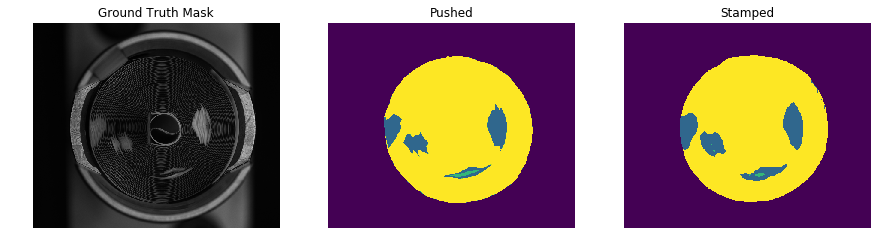

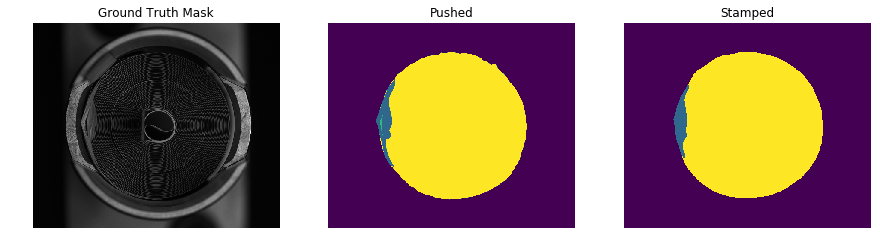

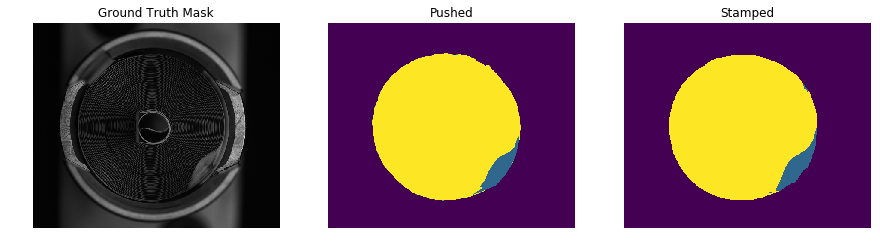

In [10]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=3)

In [11]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tqdm import tqdm
import time

In [12]:
# Load converted model and infer
model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [47]:
time_list = []
pred_mask = []

for idx,image in enumerate(tqdm(test_x)):
    start = time.time()
    image = tf.expand_dims(image,0)
    pred_mask.append(frozen_func(image)) # N, H, W, 3
    
    ex = pred_mask[idx][0][0]
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    #display([test_y[idx],pushed,stamped])
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_count = 0
    stamp_area = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100:
            continue
            
        stamp_area.append(area)
        stamp_count += 1
        #cv2.drawContours(stamped_x, [cnt], 0, (125, 125, 0), 2)  # blue

    #display([stamped_x])
    pushed_x = pushed.astype(np.uint8) * 255

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    pushed_count = 0
    push_area = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 250:
            continue
            
        push_area.append(area)
        pushed_count += 1
        #cv2.drawContours(pushed_x, [cnt], 0, (125, 125, 0), 2)  # blue

    print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
                                                                                          stamp_area, push_area))
    
    #display([pushed_x])
    
    time_list.append(time.time()-start)

 26%|██▌       | 12/46 [00:00<00:00, 50.78it/s]

Sample #0 has 1 stamps and 3 pushes. Stamp areas: [257.0], Push areas: [1902.0, 4833.0, 3451.5]
Sample #1 has 0 stamps and 1 pushes. Stamp areas: [], Push areas: [2833.0]
Sample #2 has 0 stamps and 1 pushes. Stamp areas: [], Push areas: [3857.0]
Sample #3 has 1 stamps and 3 pushes. Stamp areas: [1375.5], Push areas: [9181.5, 6456.5, 3765.0]
Sample #4 has 2 stamps and 5 pushes. Stamp areas: [691.5, 225.5], Push areas: [2309.0, 2715.0, 7659.5, 476.5, 7111.5]
Sample #5 has 2 stamps and 5 pushes. Stamp areas: [146.5, 523.0], Push areas: [5102.5, 2707.5, 288.5, 2787.0, 4118.0]
Sample #6 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [418.0, 723.0, 2254.0, 1737.5]
Sample #7 has 1 stamps and 2 pushes. Stamp areas: [284.5], Push areas: [2081.5, 3099.5]
Sample #8 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [1262.0, 1991.0, 1409.5, 1958.0]
Sample #9 has 0 stamps and 2 pushes. Stamp areas: [], Push areas: [1730.0, 1565.5]
Sample #10 has 2 stamps and 3 pushes. Stamp areas: [49

 54%|█████▍    | 25/46 [00:00<00:00, 56.81it/s]

Sample #13 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #14 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #15 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #16 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #17 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #18 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #19 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #20 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #21 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #22 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #23 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #24 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #25 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []


 85%|████████▍ | 39/46 [00:00<00:00, 60.23it/s]

Sample #26 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #27 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #28 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #29 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #30 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #31 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #32 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #33 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #34 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #35 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #36 has 2 stamps and 4 pushes. Stamp areas: [766.0, 185.5], Push areas: [2010.5, 2431.5, 7950.0, 6943.0]
Sample #37 has 2 stamps and 4 pushes. Stamp areas: [189.0, 456.5], Push areas: [5271.0, 2684.5, 2616.0, 3238.5]
Sample #38 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [386.5, 4

100%|██████████| 46/46 [00:00<00:00, 62.15it/s]

Sample #40 has 1 stamps and 2 pushes. Stamp areas: [106.5], Push areas: [1209.5, 427.0]
Sample #41 has 0 stamps and 1 pushes. Stamp areas: [], Push areas: [1699.5]
Sample #42 has 1 stamps and 2 pushes. Stamp areas: [164.0], Push areas: [2549.0, 1822.5]
Sample #43 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [1253.0, 1679.0, 1547.0, 1910.5]
Sample #44 has 0 stamps and 2 pushes. Stamp areas: [], Push areas: [1817.0, 1637.5]
Sample #45 has 2 stamps and 3 pushes. Stamp areas: [290.5, 130.0], Push areas: [2036.5, 9219.5, 912.0]


In [46]:
print("Average inference time is: ",np.mean(time_list) * 1000, "ms")
print(time_list)

Average inference time is:  14.466959497202998 ms
[0.019174814224243164, 0.014946937561035156, 0.01505279541015625, 0.01373910903930664, 0.013981819152832031, 0.014714241027832031, 0.014635562896728516, 0.020145416259765625, 0.01601552963256836, 0.01348423957824707, 0.013678312301635742, 0.014554738998413086, 0.013833999633789062, 0.013934850692749023, 0.014168739318847656, 0.013872146606445312, 0.01378941535949707, 0.013990163803100586, 0.013868331909179688, 0.013698339462280273, 0.013240337371826172, 0.013785839080810547, 0.01831364631652832, 0.01548004150390625, 0.014883279800415039, 0.013603448867797852, 0.013130903244018555, 0.013862133026123047, 0.014638423919677734, 0.013924837112426758, 0.014447927474975586, 0.013273000717163086, 0.013580083847045898, 0.014853954315185547, 0.013311386108398438, 0.013489007949829102, 0.014199972152709961, 0.014002799987792969, 0.013494729995727539, 0.013556241989135742, 0.013491392135620117, 0.014020681381225586, 0.0139617919921875, 0.0147385597

Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [16]:
print(np.shape(pred_mask[0][0][0]))

(480, 576, 4)


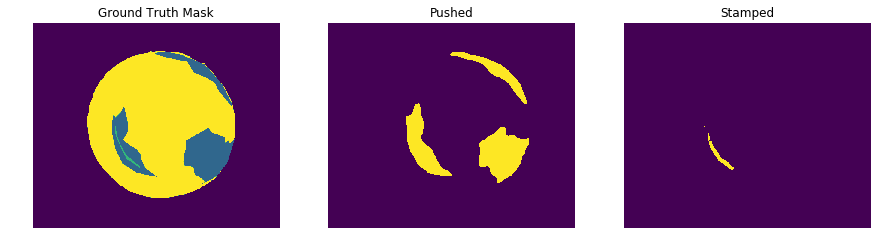

In [28]:
idx = 3

ex = pred_mask[idx][0][0]
pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
circle = np.round(tf.expand_dims(ex[:,:,3], -1))
stamped = np.round(tf.expand_dims(ex[:,:,2], -1))

display([test_y[idx],pushed,stamped])
#cv2.imwrite("stamped.png", stamped)

#display([tf.expand_dims(ex[:,:,1], -1), tf.expand_dims(ex[:,:,3], -1), tf.expand_dims(ex[:,:,2], -1)])

Parameter setting for "Stamped"

In [29]:
stamped_x = stamped.astype(np.uint8) * 255

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

#closed_stamp = cv2.morphologyEx(stamped_x, cv2.MORPH_CLOSE, k)

closed_stamp = cv2.dilate(stamped_x, k)

#cv2.imshow("stamp", closed_stamp)

1375.5
There are 1 stamp


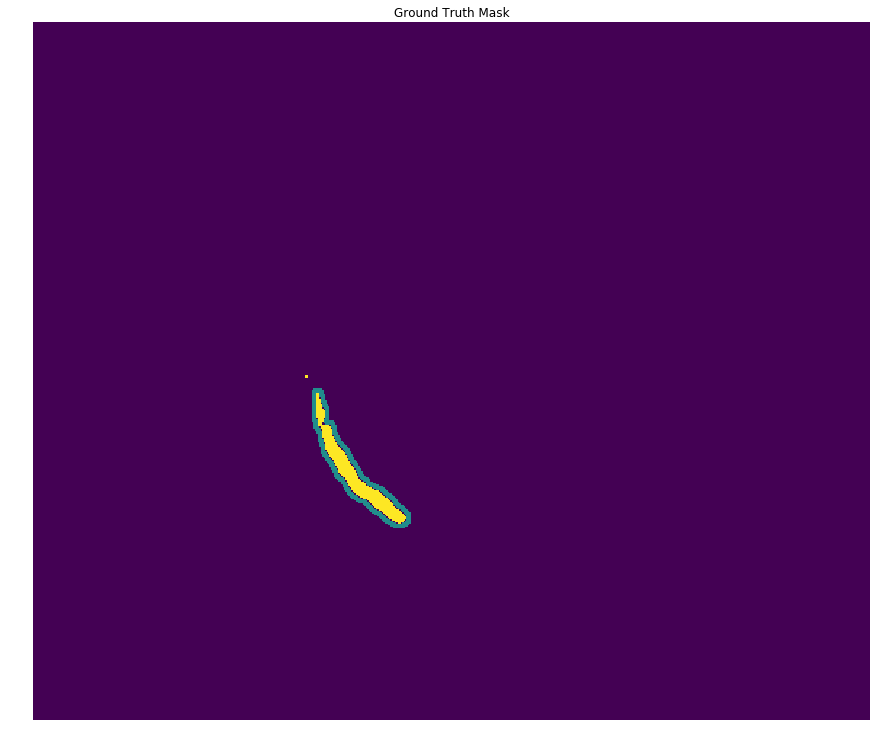

In [30]:
contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
stamp_count = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 100:
        continue
    print(area)
    stamp_count += 1
    
    cv2.drawContours(stamped_x, [cnt], 0, (125, 125, 0), 2)  # blue
    
print("There are {} stamp".format(stamp_count))
display([stamped_x])

In [31]:
pushed_x = pushed.astype(np.uint8) * 255

k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
# 닫힘 연산 적용 ---③
closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)

#cv2_imshow(closing)

9181.5
6456.5
3765.0
There are 3 stamp


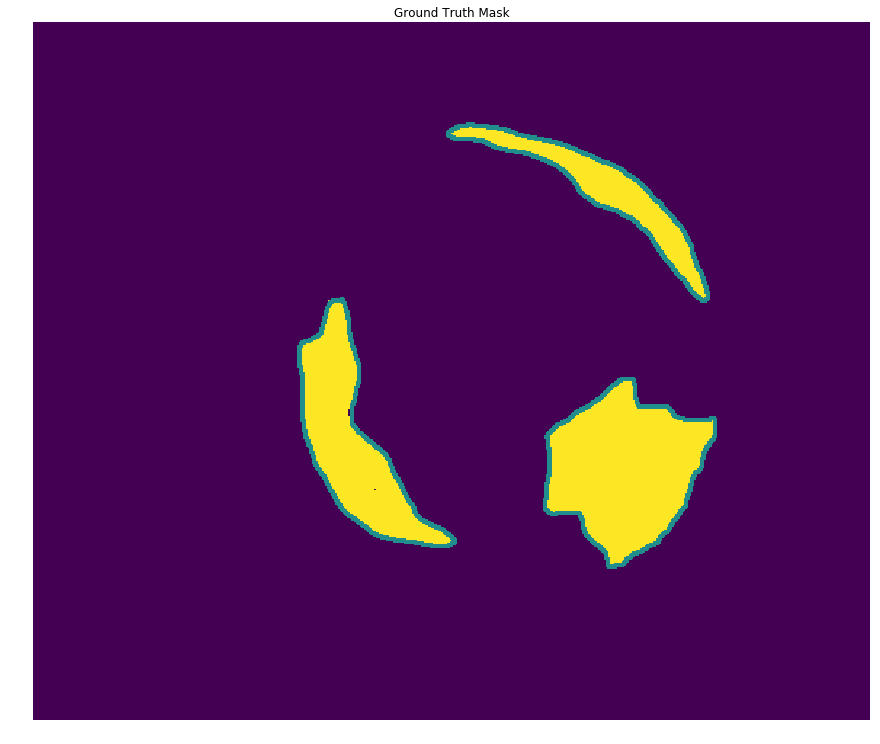

In [32]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

pushed_count = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 250:
        continue
    print(area)
    pushed_count += 1
    
    cv2.drawContours(pushed_x, [cnt], 0, (125, 125, 0), 2)  # blue
    
print("There are {} stamp".format(pushed_count))
display([pushed_x])

In [18]:
import cv2
detector = cv2.SimpleBlobDetector()
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 0
params.maxThreshold = 255

#params.minRepeatability = 2

# Filter by Area.
params.filterByArea = True
params.minArea = 300 #400
params.maxArea = 1e35

# Filter by Color (black=0)
params.filterByColor = True
params.blobColor = 255

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0
params.maxConvexity = 1

# Filter by InertiaRatio
params.filterByInertia = True
params.minInertiaRatio = 0
params.maxInertiaRatio = 1

# Distance Between Blobs
params.minDistBetweenBlobs = 70

detector = cv2.SimpleBlobDetector_create(params)

The blob with location 356x99 has size of 25.805822372436523


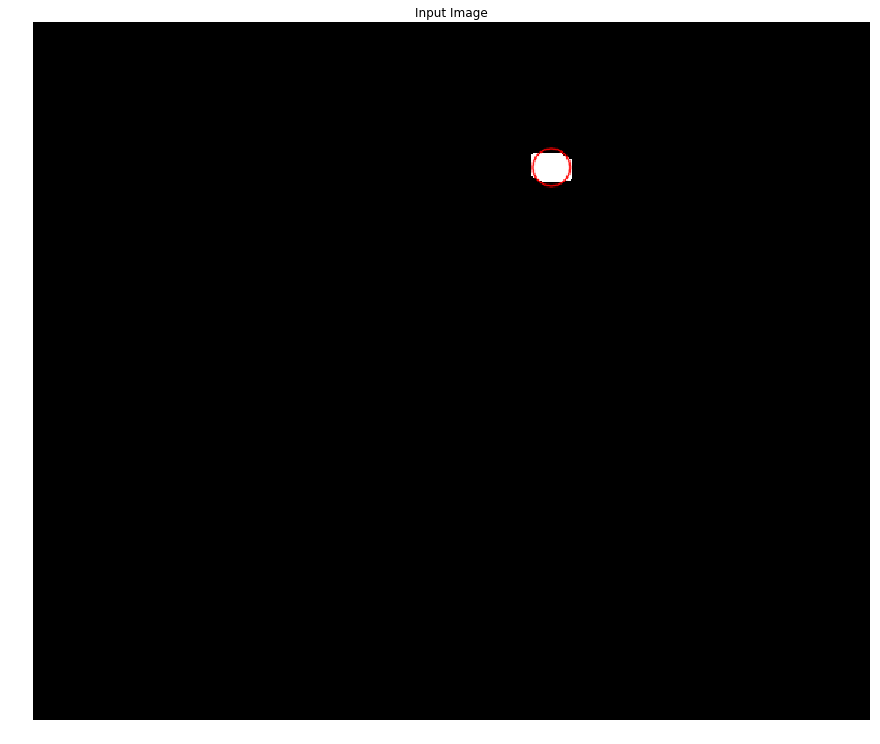

1 stamps detected


In [118]:
import math

keypoints = detector.detect(closed_stamp)
stamp_count = 0

for keypoint in keypoints:
   x = int(keypoint.pt[0])
   y = int(keypoint.pt[1])
   s = keypoint.size
   r = int(math.floor(s/2))
   print ("The blob with location {}x{} has size of {}".format(x,y,s))
   #cv2.circle(img, (x, y), r, (0, 0, 255), 2)
   stamp_count += 1

# Draw blobs
blobs = cv2.drawKeypoints(closed_stamp, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display([blobs])

print("{} stamps detected".format(stamp_count))

Parameter for "Pushed"

In [119]:
params.minArea = 170 #410
params.minDistBetweenBlobs = 50


params.minInertiaRatio = 0.013
params.maxInertiaRatio = 1 #exclude long ones

detector = cv2.SimpleBlobDetector_create(params)

In [53]:
keypoints = detector.detect(closing)
pushed_count = 0

for keypoint in keypoints:
   x = int(keypoint.pt[0])
   y = int(keypoint.pt[1])
   s = keypoint.size
   r = int(math.floor(s/2))
   print ("The blob with location {}x{} has size of {}".format(x,y,np.round(s)))
   #cv2.circle(img, (x, y), r, (0, 0, 255), 2)
   pushed_count += 1

# Draw blobs
blobs = cv2.drawKeypoints(closing, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display([blobs])

print("{} pushes detected".format(pushed_count))

NameError: name 'math' is not defined